In [16]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[6]") \
   .appName("ToxicCommentAnalysis") \
   .enableHiveSupport() \
   .getOrCreate()

sc = spark.sparkContext

In [17]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
train = pd.read_csv('data/train.csv')

train['comment_text'].fillna("unknown", inplace=True)

In [19]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# k = pd.DataFrame()
# k['train'] = train.isnull().sum()
# k['test'] = test.isnull().sum()
# k

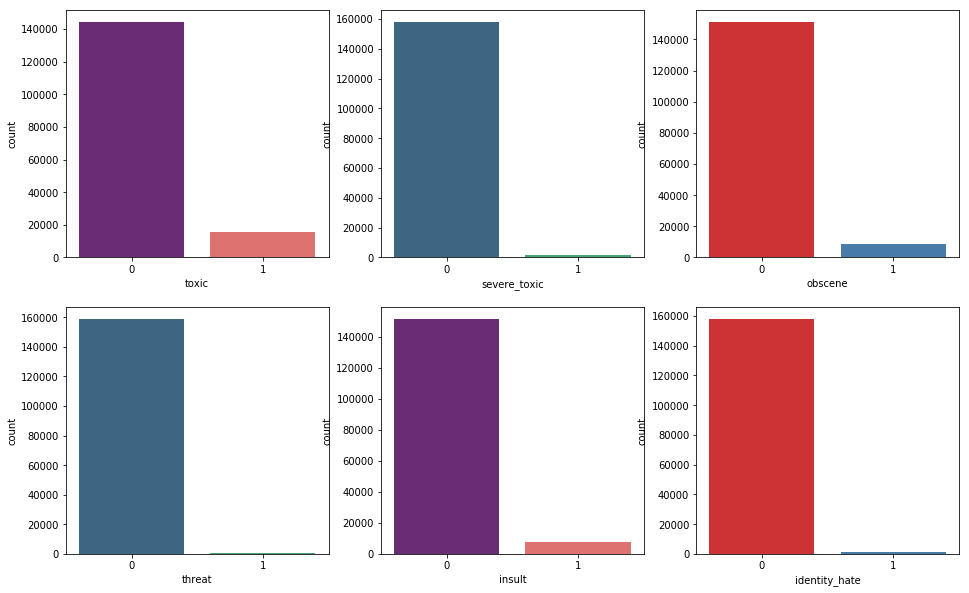

In [22]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

In [23]:
from wordcloud import WordCloud,STOPWORDS
from ast import literal_eval

def getWordCloud(path,label):
    with open(path,'r') as f:
        fd = f.read()
    res = literal_eval(fd)
    length = len(fd)
    print(label,'- total words: ',length)
#     print(type(res))


    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=STOPWORDS,width=1200,height=600,scale=1.5).generate_from_text(','.join(res))

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    # The pil way (if you don't have matplotlib)
    # image = wordcloud.to_image()
    # image.show()

toxic - total words:  4086904


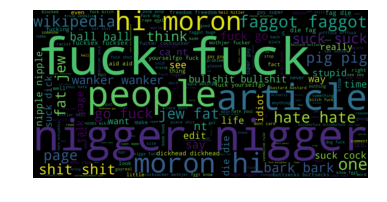

severe_toxic - total words:  702859


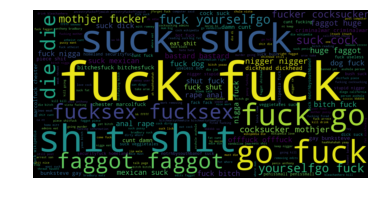

obscene - total words:  2228411


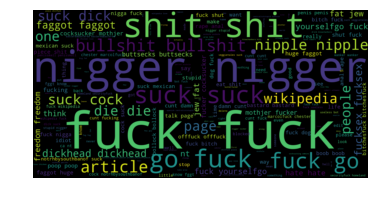

threat - total words:  124527


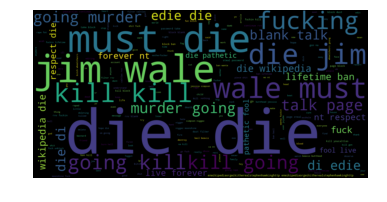

insult - total words:  2000649


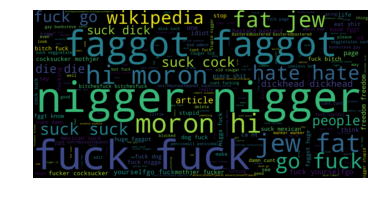

identity_hate - total words:  429209


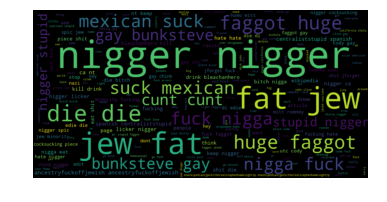

In [24]:
all_label = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
for i in all_label:
    path = 'words/'+i+'_words.txt'
    getWordCloud(path,i)

In [25]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# print(string.punctuation)
def mytoken_lemm(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    lemms = []
    for item in words:
        lemms.append(WordNetLemmatizer().lemmatize(item))
    return lemms

In [26]:
# tokenize
train['comment_text'] = train['comment_text'].map(lambda com : mytoken_lemm(com))

In [27]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,000103f0d9cfb60f,"[daww, match, background, colour, seemingly, s...",0,0,0,0,0,0
2,000113f07ec002fd,"[hey, man, really, trying, edit, war, guy, con...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"[ca, nt, make, real, suggestion, improvement, ...",0,0,0,0,0,0
4,0001d958c54c6e35,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [28]:
# pd df -> spark df
train_df = spark.createDataFrame(train)

In [29]:
trainDF = train_df.select([column for column in train_df.columns if column != 'id'])

In [30]:
trainDF.dtypes

[('comment_text', 'array<string>'),
 ('toxic', 'bigint'),
 ('severe_toxic', 'bigint'),
 ('obscene', 'bigint'),
 ('threat', 'bigint'),
 ('insult', 'bigint'),
 ('identity_hate', 'bigint')]

In [31]:
trainDF.show(1)

+--------------------+-----+------------+-------+------+------+-------------+
|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|[explanation, edi...|    0|           0|      0|     0|     0|            0|
+--------------------+-----+------------+-------+------+------+-------------+
only showing top 1 row



In [32]:
trainDF.printSchema()

root
 |-- comment_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- toxic: long (nullable = true)
 |-- severe_toxic: long (nullable = true)
 |-- obscene: long (nullable = true)
 |-- threat: long (nullable = true)
 |-- insult: long (nullable = true)
 |-- identity_hate: long (nullable = true)



In [33]:
from pyspark.ml.feature import HashingTF,IDF,Tokenizer,RegexTokenizer,VectorAssembler

hashingTF = HashingTF(inputCol="comment_text", outputCol="rawCommentText", numFeatures=2000)
# featurizedData = hashingTF.transform(trainDF)
# featurizedData.dtypes

idf = IDF(inputCol="rawCommentText", outputCol="features")
# idfModel = idf.fit(featurizedData)
# finalTrainDF = idfModel.transform(featurizedData)
# finalTrainDF.dtypes

In [34]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[hashingTF, idf])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(trainDF)
trainingDF = pipelineFit.transform(trainDF)

In [35]:
# help(pipelineFit.save)
pipelineFit.write().overwrite().save('./models/tfidf-model') 

In [36]:
trainingDF.select('features','toxic').show(3)

+--------------------+-----+
|            features|toxic|
+--------------------+-----+
|(2000,[25,107,177...|    0|
|(2000,[86,567,925...|    0|
|(2000,[166,213,22...|    0|
+--------------------+-----+
only showing top 3 rows



In [37]:
trainingDF.printSchema()

root
 |-- comment_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- toxic: long (nullable = true)
 |-- severe_toxic: long (nullable = true)
 |-- obscene: long (nullable = true)
 |-- threat: long (nullable = true)
 |-- insult: long (nullable = true)
 |-- identity_hate: long (nullable = true)
 |-- rawCommentText: vector (nullable = true)
 |-- features: vector (nullable = true)



In [38]:
# trainingData = finalTrainDF
# testData = test_df
(trainingData, testData) = trainingDF.randomSplit([0.7, 0.3], seed = 100)

## Logistic Regression

In [39]:
from pyspark.ml.classification import LogisticRegression
import time

startTime = time.time()
lr = LogisticRegression(labelCol="toxic", featuresCol="features",maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

lrModel.write().overwrite().save('./models/lr-model') 

executeTime = time.time() - startTime
print ('Training Time For Logistic Regression = %s' % str(executeTime) + ' Seconds\n')

Training Time For Logistic Regression = 12.496969938278198 Seconds



In [40]:
Predictions = lrModel.transform(testData)
Predictions.filter(Predictions['prediction'] == 1) \
    .select("toxic","probability","comment_text","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 50, truncate = 40)

+-----+----------------------------------------+----------------------------------------+----------+
|toxic|                             probability|                            comment_text|prediction|
+-----+----------------------------------------+----------------------------------------+----------+
|    1|[0.48615247404523143,0.5138475259547686]|[gwernolugly, stillborn, molesting, d...|       1.0|
|    0|[0.46850262472232423,0.5314973752776758]|[bye, bye, bye, bye, bye, bye, bye, b...|       1.0|
|    0|[0.45935129086746523,0.5406487091325348]|[weezer, okay, weezer, okay, weezer, ...|       1.0|
|    0| [0.4281364628304904,0.5718635371695097]|[say, grasping, straw, say, denying, ...|       1.0|
|    1| [0.42156911075436804,0.578430889245632]|[bastard, proassad, rebel, aleppo, ce...|       1.0|
|    1|[0.42125789860390744,0.5787421013960926]|[mothjer, fucker, cocksucker, mothjer...|       1.0|
|    1| [0.36937839001297096,0.630621609987029]|[rodullandemu, coming, ya, jewish, fu...|  

In [41]:
# Predictions.select("toxic","probability","comment_text","prediction") \
#     .orderBy("probability", ascending=False) \
#     .show(n = 50, truncate = 40)

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="toxic",predictionCol="prediction",metricName="accuracy")
lg_accuracy = evaluator.evaluate(Predictions)
print("Test Error = %g" % (1.0 - lg_accuracy))
print("Test Accuracy = %g" % lg_accuracy)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='toxic', metricName='areaUnderROC')
lg_roc = evaluator.evaluate(Predictions)
print("Test ROC = %g" %lg_roc)
lg_pr = evaluator.evaluate(Predictions, {evaluator.metricName: "areaUnderPR"})
print("Test PR = %g" %lg_pr)

Test Error = 0.0939614
Test Accuracy = 0.906039
Test ROC = 0.50521
Test PR = 0.480014


In [43]:
# lr = LogisticRegression(labelCol='threat', featuresCol="features",maxIter=20, regParam=0.3, elasticNetParam=0)
# lrModel = lr.fit(trainingData)
# print('fit','threat',lrModel)
# Predictions = lrModel.transform(testData)
# Predictions.select("toxic","probability","comment_text","prediction").show(n = 5, truncate = 40)
# evaluator = MulticlassClassificationEvaluator(labelCol='threat',predictionCol="prediction",metricName="accuracy").evaluate(Predictions)
# print("Test Accuracy = %g" % lg_accuracy)

# lr = LogisticRegression(labelCol='insult', featuresCol="features",maxIter=20, regParam=0.3, elasticNetParam=0)
# lrModel = lr.fit(trainingData)
# print('fit','insult',lrModel)
# Predictions = lrModel.transform(testData)
# Predictions.select("toxic","probability","comment_text","prediction").show(n = 5, truncate = 40)
# evaluator = MulticlassClassificationEvaluator(labelCol='insult',predictionCol="prediction",metricName="accuracy").evaluate(Predictions)
# print("Test Accuracy = %g" % lg_accuracy)

In [44]:
# def runlg(label):
#     lr = LogisticRegression(labelCol=label, featuresCol="features",maxIter=20, regParam=0.3, elasticNetParam=0)
#     lrModel = lr.fit(trainingData)
#     print('fit',label,lrModel)
#     Predictions = lrModel.transform(testData)
#     evaluator = MulticlassClassificationEvaluator(labelCol=label,predictionCol="prediction",metricName="accuracy").evaluate(Predictions)
#     print("Test Accuracy = %g" % lg_accuracy)


In [45]:
# for label in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
#     runlg(label)

## Decision Tree

In [46]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import time

startTime = time.time()

dt = DecisionTreeClassifier(labelCol="toxic", featuresCol="features")
dtModel = dt.fit(trainingData)

dtModel.write().overwrite().save('./models/dt-model') 

endTime = time.time()
executeTime = endTime - startTime
print ('Training Time For Decision Tree = %s' % str(executeTime) + ' Seconds\n')


Training Time For Decision Tree = 56.6533260345459 Seconds



In [47]:
Predictions = dtModel.transform(testData)
Predictions.filter(Predictions['prediction'] == 1) \
    .select("toxic","probability","comment_text","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 50, truncate = 40)

+-----+----------------------------------------+----------------------------------------+----------+
|toxic|                             probability|                            comment_text|prediction|
+-----+----------------------------------------+----------------------------------------+----------+
|    0| [0.3333333333333333,0.6666666666666666]|[followup, criticism, gwen, gale, imp...|       1.0|
|    0| [0.3333333333333333,0.6666666666666666]|[wow, article, need, much, work, even...|       1.0|
|    0| [0.3333333333333333,0.6666666666666666]|[great, job, map, salute, speaking, w...|       1.0|
|    0| [0.3333333333333333,0.6666666666666666]|[list, surgeon, recently, list, surge...|       1.0|
|    1| [0.3333333333333333,0.6666666666666666]|[request, unblock, began, writing, fo...|       1.0|
|    0| [0.3333333333333333,0.6666666666666666]|[copyright, issue, content, introduce...|       1.0|
|    1|[0.19886363636363635,0.8011363636363636]|[hi, hi, fucking, retard, never, even...|  

In [48]:
# Decesion Tress Evalution
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(labelCol="toxic", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(Predictions)
print("Test Error = %g" % (1.0 - dt_accuracy))
print("Test Accuracy = %g" % dt_accuracy)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='toxic', metricName='areaUnderROC')
dt_roc = evaluator.evaluate(Predictions)
print("Test ROC = %g" %dt_roc)
dt_pr = evaluator.evaluate(Predictions, {evaluator.metricName: "areaUnderPR"})
print("Test PR = %g" %dt_pr)

Test Error = 0.0783151
Test Accuracy = 0.921685
Test ROC = 0.609195
Test PR = 0.537319


## Random Forest

In [49]:
# from pyspark.ml.classification import RandomForestClassifier
# import time

# startTime = time.time()
# rf = RandomForestClassifier(labelCol="toxic", featuresCol="features", numTrees=8)
# rfModel = rf.fit(trainingData)

# executeTime = time.time() - startTime
# print ('Training Time For Random Forest = %s' % str(executeTime) + ' Seconds\n')

In [50]:
# Predictions = rfModel.transform(testData)
# Predictions.filter(Predictions['prediction'] == 1) \
#     .select("toxic","probability","comment_text","prediction") \
#     .orderBy("probability", ascending=False) \
#     .show(n = 50, truncate = 40)

In [51]:
# evaluator = MulticlassClassificationEvaluator(labelCol="toxic", predictionCol="prediction", metricName="accuracy")
# rf_accuracy = evaluator.evaluate(Predictions)
# print("Test Error = %g" % (1.0 - rf_accuracy))
# print("Test Accuracy = %g" % rf_accuracy)

# evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='toxic', metricName='areaUnderROC')
# rf_roc = evaluator.evaluate(Predictions)
# print("Test ROC = %g" %rf_roc)
# rf_pr = evaluator.evaluate(Predictions, {evaluator.metricName: "areaUnderPR"})
# print("Test PR = %g" %rf_pr)

## Naive Bayes

In [52]:
from pyspark.ml.classification import NaiveBayes
import time

startTime = time.time()

nb = NaiveBayes(featuresCol='features', labelCol='toxic',smoothing=1.0, modelType='multinomial')
nbModel = nb.fit(trainingData)

nbModel.write().overwrite().save('./models/nb-model') 

endTime = time.time()
executeTime = endTime - startTime
print ('Training Time For NaiveBayes = %s' % str(executeTime) + ' Seconds\n')

Training Time For NaiveBayes = 6.098877906799316 Seconds



In [53]:
Predictions = nbModel.transform(testData)
Predictions.filter(Predictions['prediction'] == 1) \
    .select("toxic","probability","comment_text","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 50, truncate = 40)

+-----+----------------------------------------+----------------------------------------+----------+
|toxic|                             probability|                            comment_text|prediction|
+-----+----------------------------------------+----------------------------------------+----------+
|    0|[0.49790532020769335,0.5020946797923066]|[opposition, took, arm, syria, le, ki...|       1.0|
|    0|  [0.497847130091386,0.5021528699086141]|[right, block, people, falsely, accus...|       1.0|
|    0|[0.49674501002301563,0.5032549899769843]|              [sockpuppet, leave, alone]|       1.0|
|    0|   [0.496243898382711,0.503756101617289]|[nicole, kidman, australian, nicole, ...|       1.0|
|    0| [0.4961469403840546,0.5038530596159454]|[woah, im, fron, spokane, im, liberal...|       1.0|
|    1| [0.49590157754736797,0.504098422452632]|[figure, aspergers, pedantic, little,...|       1.0|
|    0|[0.49534736421233755,0.5046526357876625]|                         [rtl, may, gmt]|  

In [54]:
# Naive Bayes Evalution
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator


evaluator = MulticlassClassificationEvaluator(labelCol="toxic", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(Predictions)
print("Test Error = %g" % (1.0 - nb_accuracy))
print("Test Accuracy = %g" % nb_accuracy)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='toxic', metricName='areaUnderROC')
nb_roc = evaluator.evaluate(Predictions)
print("Test ROC = %g" %nb_roc)
nb_pr = evaluator.evaluate(Predictions, {evaluator.metricName: "areaUnderPR"})
print("Test PR = %g" %nb_pr)

Test Error = 0.0836353
Test Accuracy = 0.916365
Test ROC = 0.78003
Test PR = 0.464262


## Comparision

In [55]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='Charonnnnn', api_key='AbJWgmkkFaenpmi0reYX')

accuracy_ = go.Bar(
    x=['DecisionTree', 'LogisticRegression', 'NaiveBayes'],
    y=[dt_accuracy,lg_accuracy,nb_accuracy],
    name='Accuracy',
    marker=dict(
        color='rgb(242,156,177)'
    )
)
roc_ = go.Bar(
    x=['DecisionTree', 'LogisticRegression', 'NaiveBayes'],
    y=[dt_roc,lg_roc,nb_roc],
    name='ROC',
    marker=dict(
        color='#FAFAD2',
    )
)
pr_ = go.Bar(
    x=['DecisionTree', 'LogisticRegression', 'NaiveBayes'],
    y=[dt_pr,lg_pr,nb_pr],
    name='PR',
    marker=dict(
        color='#FFE1FF',
    )
)

data = [accuracy_, roc_, pr_]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='angled-text-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Charonnnnn/0 or inside your plot.ly account where it is named 'angled-text-bar'
